In [1]:
import gym
import numpy as np
from gym import spaces

In [2]:
from enum import Enum
class Actions(Enum):
    Sell = 0
    Buy = 1

In [3]:
from math import copysign
class Position:
    def __init__(self, env):
        self.__env = env
        self.size = 0
        self.entry_price = None
        self.entry_time = None
        
    def __repr__(self) -> str:
        return f"Position(size: {self.size}, entry_price: {self.entry_price}, pl: {self.profit_or_loss:.0f})"
    
    @property
    def is_long(self) -> bool:
        return True if self.size > 0 else False

    @property
    def is_short(self) -> bool:
        return True if self.size < 0 else False

    @property
    def profit_or_loss(self):
        if self.size == 0:
            return 0
        return self.size * (self.__env.current_price - self.entry_price)

    @property
    def profit_or_loss_pct(self):
        if self.size == 0:
            return 0
        return copysign(1, self.size) * (self.__env.current_price - self.entry_price) / self.entry_price

    def close(self):
        if self.size == 0:
            return
        self.__env.wallet.assets += self.profit_or_loss
        trade = {
            "size": self.size,
            "entry_price": self.entry_price,
            "exit_price": self.__env.current_price,
            "PnL": self.profit_or_loss,
            "entry_time": self.entry_time,
            "exit_time": self.__env.current_datetime,
        }
        self.__env.closed_trades = self.__env.closed_trades.append(trade, ignore_index=True)
        self.size = 0
        self.entry_price = None
        self.entry_time = None    

In [4]:
class Wallet:
    def __init__(self, env, assets:float = 1000000):
        self.__env = env
        self.assets = assets

    @property
    def equity(self) -> float:
        return self.assets + self.__env.position.profit_or_loss

    @property
    def free_assets(self) -> float:
        used_assets = abs(self.__env.position.size) * self.__env.current_price
        return max(0, self.equity - used_assets)   

In [5]:
class SimpleTradingEnv(gym.Env):
    def __init__(self, df, preprocessed_df, window_size, fee):
        self._df = df.copy()
        self._preprocessed_df = preprocessed_df
        self.fee = fee
        self.window_size = window_size
        self.action_space = spaces.Discrete(2)
        self.observation_size = len(self._preprocessed_df.columns)  # positionの情報を持つか検討する
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.window_size, self.observation_size))
        self.current_step = 0
        self.position = None
        self.wallet = None
        self.closed_trades = None

    def reset(self):
        self.current_step = self.window_size
        self.position = Position(self)
        self.wallet = Wallet(self)
        self.observation = self._preprocessed_df.iloc[:self.window_size, :]
        self.prev_profit_or_loss_pct = 0
        self.closed_trades = pd.DataFrame(columns=["size", "entry_price", "exit_price", "PnL", "entry_time", "exit_time"])
        return self.observation

    def step(self, action):
        self.action = action
        
        if self.action == Actions.Buy.value and not self.position.is_long:
            self.buy()

        elif self.action == Actions.Sell.value and not self.position.is_short:
            self.sell()

        self.done = True if self.current_step + 1 == len(self._df) else False
        if self.done:
            self.position.close()

        self.observation = self.next_observation
        self.reward = self._calculate_reward()
        self.info = {}

        self.current_step += 1
        return self.observation, self.reward, self.done, self.info

    def render(self, mode='human'):
        print(f"Step: {self.current_step}")
        print(f"Assets: {self.wallet.assets}, Equity: {self.wallet.equity}")
        print(f"Position: {self.position.size}, {self.position.profit_or_loss}")
        print(f"Action: {self.action}, Reward: {self.reward}, Done: {self.done}")
        print(self.closed_trades.tail(1))

    def buy(self):
        if self.position.size == 0:
            adjusted_price = self.current_price * (1 + self.fee)
            self.position.size = int(self.wallet.free_assets // adjusted_price)
            self.position.entry_price = adjusted_price
            self.position.entry_time = self.current_datetime

        elif self.position.is_short:
            self.position.close()

    def sell(self):
        if self.position.size == 0:
            adjusted_price = self.current_price * (1 - self.fee)
            self.position.size = -int(self.wallet.free_assets // adjusted_price)
            self.position.entry_price = adjusted_price
            self.position.entry_time = self.current_datetime

        elif self.position.is_long:
            self.position.close()

    def _calculate_reward(self):
        reward = self.position.profit_or_loss_pct - self.prev_profit_or_loss_pct * 100
        self.prev_profit_or_loss_pct = self.position.profit_or_loss_pct
        return reward

    @property
    def next_observation(self):
        return self._preprocessed_df[self.current_step - self.window_size + 1:self.current_step + 1]

    @property
    def current_price(self):
        return self._df["Close"][self.current_step]

    @property
    def current_datetime(self):
        return self._df.iloc[self.current_step, :].name

In [6]:
import pandas as pd
import os

from utils import preprocessing
from models.cnn_features_extractor import CustomCNN

from stable_baselines3 import DQN, PPO
from stable_baselines3.common.env_checker import check_env


Loading BokehJS ...

In [7]:
window_size = 20
fee = 0.000665

In [8]:
df = pd.read_csv("./data/3600/ethusd/2021-01-01.csv", parse_dates=[0]).set_index("Date")
train_df = df[: len(df) // 2]
eval_df = df[len(df) // 2 :]
train_env = SimpleTradingEnv(train_df, preprocessing(df), window_size=window_size, fee=fee)
eval_env = SimpleTradingEnv(eval_df, preprocessing(df), window_size=window_size, fee=fee)

In [9]:
policy_kwargs = dict(
    features_extractor_class=CustomCNN,
    features_extractor_kwargs=dict(features_dim=128),
)
model = PPO("CnnPolicy", train_env, verbose=0, tensorboard_log="./logs", policy_kwargs=policy_kwargs)
model_name = model.__class__.__name__
model.learn(15000)
model.save(f"./results/{model_name}")
del model

(20, 11)
Step: 21
Assets: 1000000, Equity: 994580.2282525001
Position: 517, -5419.771747499966
Action: 1, Reward: -0.0006645580688841347, Done: False
Empty DataFrame
Columns: [size, entry_price, exit_price, PnL, entry_time, exit_time]
Index: []
Step: 22
Assets: 1000000, Equity: 995769.3282525
Position: 517, -4230.67174749999
Action: 1, Reward: -0.004764905968264479, Done: False
Empty DataFrame
Columns: [size, entry_price, exit_price, PnL, entry_time, exit_time]
Index: []
Step: 23
Assets: 995769.3282525, Equity: 995769.3282525
Position: 0, 0
Action: 0, Reward: 0.005429464037148613, Done: False
  size  entry_price  exit_price          PnL          entry_time  \
0  517  1930.783117      1922.6 -4230.671747 2021-04-01 20:00:00   

            exit_time  
0 2021-04-01 22:00:00  
Step: 24
Assets: 995769.3282525, Equity: 993360.4626265002
Position: 514, -2408.865625999825
Action: 1, Reward: -0.0006645580688840869, Done: False
  size  entry_price  exit_price          PnL          entry_time  \

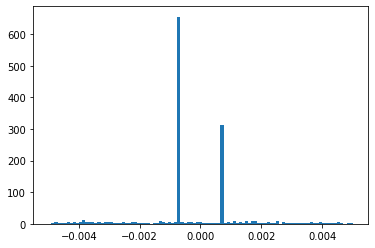

In [10]:
import matplotlib.pyplot as plt
def evaluate(model, env, render=True) -> np.ndarray:
    state = env.reset()
    print(state.shape)
    done = False

    episode_rewards = []

    while not done:
        action, state = model.predict(state)
        state, reward, done, info = env.step(action)

        if render:
            env.render()

        episode_rewards.append(reward)

        if done:
            break

    return np.array(episode_rewards)

model = PPO.load("./results/PPO")
episode_rewards = evaluate(model, eval_env)
fig, axs = plt.subplots(1, 1)
bins = np.linspace(-0.005, 0.005, 100)
n, bins, patches = axs.hist(episode_rewards, bins=bins)

In [11]:
import warnings
from bokeh.util.warnings import BokehDeprecationWarning

warnings.simplefilter("ignore", BokehDeprecationWarning)
warnings.simplefilter("ignore", UserWarning)
from backtesting import Strategy, Backtest


class DRLStrategy(Strategy):
    model = None
    env = None

    def init(self):
        self.state = self.env.reset()
        self.max_step = len(self.data.df) - 1

    def next(self):
        self.step = len(self.data.df) - 1
        self.env.current_step = self.step  # BacktestのステップとEnvironmentのステップを同期させる

        if self.step < self.env.window_size:
            return

        assert self._broker._cash == self.env.wallet.assets, f"Step:{self.step}/{self.max_step}: {self._broker._cash} != {self.env.wallet.assets}"
        assert self.equity == self.env.wallet.equity, f"Step{self.step}/{self.max_step}: {self.equity} != {self.env.wallet.equity}"

        if self.step == self.max_step:
            self.env.position.close()
            return

        action, _ = self.model.predict(self.env.next_observation)

        if action == Actions.Buy.value and not self.position.is_long:
            if self.position.is_short:
                self.position.close()
            else:
                self.buy()
            self.env.buy()

        elif action == Actions.Sell.value and not self.position.is_short:
            if self.position.is_long:
                self.position.close()
            else:
                self.sell()
            self.env.sell()


def backtest(model, env, plot=False, plot_filename=None):
    bt = Backtest(env._df, DRLStrategy, cash=env.wallet.assets, commission=env.fee, trade_on_close=True, exclusive_orders=False)
    stats = bt.run(model=model, env=env)
    if plot:
        bt.plot(filename=plot_filename)
    print("Finished Backtest")
    return stats

In [12]:
model = PPO.load("./results/PPO")
train_env.reset()
eval_env.reset()
print(train_env.wallet.assets)
stats_train = backtest(model, train_env, plot=True, plot_filename=f"./results/BackTest-PPO-train")
stats_eval = backtest(model, eval_env, plot=True, plot_filename=f"./results/BackTest-PPO-eval")

stats = pd.DataFrame()
stats["train"] = stats_train
stats["eval"] = stats_eval
# stats = stats.drop(["Best Trade [%]", "Worst Trade [%]", "_strategy", "_equity_curve", "_trades"], axis=0)
print(stats)

1000000
Finished Backtest
Finished Backtest
                                                                    train  \
Start                                                 2021-01-01 00:00:00   
End                                                   2021-03-31 23:00:00   
Duration                                                 89 days 23:00:00   
Exposure Time [%]                                               99.027778   
Equity Final [$]                                            625599.791446   
Equity Peak [$]                                            1280090.133309   
Return [%]                                                     -37.440021   
Buy & Hold Return [%]                                          149.948745   
Return (Ann.) [%]                                              -85.282647   
Volatility (Ann.) [%]                                           20.190293   
Sharpe Ratio                                                          0.0   
Sortino Ratio                   

In [13]:
stats.loc["_strategy", "train"].env.closed_trades

,size,entry_price,exit_price,PnL,entry_time,exit_time
0,1353,739.061149,741.60,3435.065335,2021-01-01 20:00:00,2021-01-01 23:00:00
1,-1357,739.048206,736.63,3281.505406,2021-01-02 00:00:00,2021-01-02 01:00:00
2,1365,737.390038,726.93,-14277.952552,2021-01-02 02:00:00,2021-01-02 05:00:00
3,1356,731.506128,729.49,-2733.869975,2021-01-02 06:00:00,2021-01-02 07:00:00
4,1354,730.745623,730.69,-75.313407,2021-01-02 08:00:00,2021-01-02 09:00:00
...,...,...,...,...,...,...
664,344,1841.523799,1832.10,-3241.787028,2021-03-30 22:00:00,2021-03-30 23:00:00
665,342,1838.621871,1841.70,1052.720118,2021-03-31 00:00:00,2021-03-31 09:00:00
666,-339,1857.963632,1848.10,3343.771248,2021-03-31 10:00:00,2021-03-31 11:00:00
667,344,1841.023467,1808.50,-11188.072648,2021-03-31 12:00:00,2021-03-31 18:00:00


In [14]:
stats.loc["_trades", "train"]

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
0,1353,20,23,739.061149,741.60,3435.065335,0.003435,2021-01-01 20:00:00,2021-01-01 23:00:00,0 days 03:00:00
1,-1357,24,25,739.048206,736.63,3281.505406,0.003272,2021-01-02 00:00:00,2021-01-02 01:00:00,0 days 01:00:00
2,1365,26,29,737.390038,726.93,-14277.952552,-0.014185,2021-01-02 02:00:00,2021-01-02 05:00:00,0 days 03:00:00
3,1356,30,31,731.506128,729.49,-2733.869975,-0.002756,2021-01-02 06:00:00,2021-01-02 07:00:00,0 days 01:00:00
4,1354,32,33,730.745623,730.69,-75.313407,-0.000076,2021-01-02 08:00:00,2021-01-02 09:00:00,0 days 01:00:00
...,...,...,...,...,...,...,...,...,...,...
664,344,2134,2135,1841.523799,1832.10,-3241.787028,-0.005117,2021-03-30 22:00:00,2021-03-30 23:00:00,0 days 01:00:00
665,342,2136,2145,1838.621871,1841.70,1052.720118,0.001674,2021-03-31 00:00:00,2021-03-31 09:00:00,0 days 09:00:00
666,-339,2146,2147,1857.963632,1848.10,3343.771248,0.005309,2021-03-31 10:00:00,2021-03-31 11:00:00,0 days 01:00:00
667,344,2148,2154,1841.023467,1808.50,-11188.072648,-0.017666,2021-03-31 12:00:00,2021-03-31 18:00:00,0 days 06:00:00
